In [4]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import lightgbm as lgb
import matplotlib.pyplot as plt

In [5]:
import warnings

## Loading Dataset and change values to english

In [40]:
global train, test

In [41]:
train = pd.read_hdf('input/train.h5')
test = pd.read_hdf('input/test.h5')

In [7]:
train.shape

(2699638, 7)

In [8]:
test.shape

(782378, 6)

In [49]:
train.type.unique()

array(['围网', '拖网', '刺网'], dtype=object)

In [50]:
data_dict = {'围网': 'seine', '拖网': 'trawling', '刺网': 'gillnetting'}

In [51]:
train['type'] = train.type.map(data_dict)

In [52]:
train.head()

,ship,x,y,v,d,time,type
0,6966,6.265902e+06,5.279254e+06,0.11,306,1106 23:58:16,seine
1,6966,6.265902e+06,5.279254e+06,0.00,0,1106 23:48:21,seine
2,6966,6.265902e+06,5.279254e+06,0.00,0,1106 23:38:19,seine
3,6966,6.265902e+06,5.279254e+06,0.00,0,1106 23:28:36,seine
4,6966,6.265902e+06,5.279254e+06,0.32,130,1106 23:08:17,seine


## Further Data Understanding

Look at the mean/max/min of v, position, position/v change, and change of d

As well as the trajectary of ship

In [53]:
train.ship.unique()

array([6966,  545,  223, ..., 1962, 1976, 3807])

### Look at the 6966 speed 

In [54]:
x = train[train['ship'] == 6966]

In [55]:
train[train.v > 30][['ship', 'v']].head()

,ship,v
292,4624,60.55
293,4624,60.55
67,2916,30.28
45,1199,60.55
0,1167,30.28


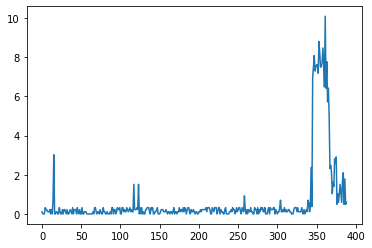

In [16]:
plt.plot(x['v'])

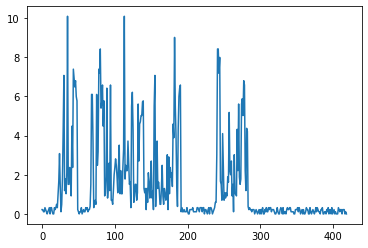

In [18]:
x1 = train[(train.type == 'gillnetting') & (train['ship'] == 4803)]
plt.plot(x1['v'])

In [19]:
gillnetting_array = train[train.type == 'gillnetting'].ship.unique()
trawling_array = train[train.type == 'trawling'].ship.unique()
seine_array = train[train.type == 'seine'].ship.unique()

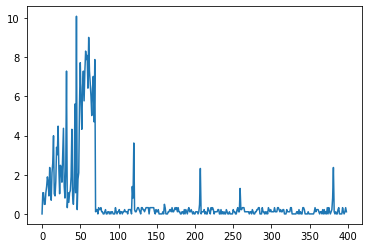

In [20]:
x2 = train[(train.type == 'gillnetting') & (train['ship'] == 3163)]
plt.plot(x2['v'])

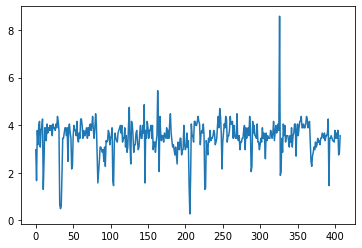

In [21]:
x3 = train[(train.type == 'trawling') & (train['ship'] == trawling_array[2])]
plt.plot(x3['v'])

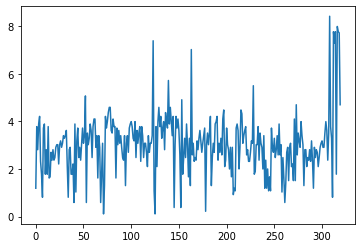

In [22]:
x3 = train[(train.type == 'trawling') & (train['ship'] == trawling_array[4])]
plt.plot(x3['v'])

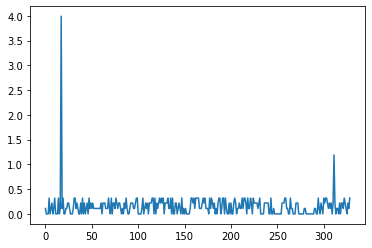

In [23]:
x3 = train[(train.type == 'seine') & (train['ship'] == seine_array[4])]
plt.plot(x3['v'])

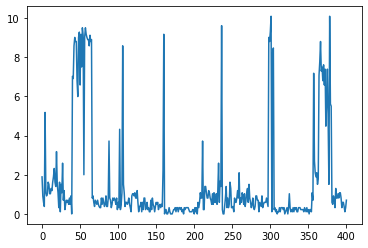

In [24]:
x3 = train[(train.type == 'seine') & (train['ship'] == seine_array[20])]
plt.plot(x3['v'])

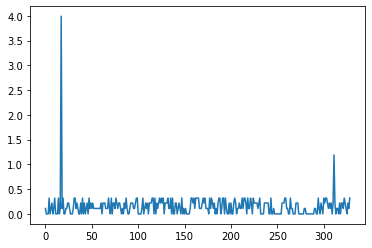

In [25]:
x3 = train[(train.type == 'seine') & (train['ship'] == seine_array[4])]
plt.plot(x3['v'])

In [56]:
import random
def plot_fishing_speed(data_, fish_type):
    gillnetting_array = data_[data_.type == 'gillnetting'].ship.unique()
    trawling_array = data_[data_.type == 'trawling'].ship.unique()
    seine_array = data_[data_.type == 'seine'].ship.unique()
    
    gillnetting_plot = random.sample(list(gillnetting_array), 20)
    trawling_plot = random.sample(list(trawling_array), 20)
    seine_plot = random.sample(list(seine_array), 20)
    
    f, ax = plt.subplots(10, 2, figsize=(12, 50))
    
    if fish_type == 'gillnet':
        ships = data_[data_['ship'].isin(gillnetting_plot)]
        for index, v_id in enumerate(gillnetting_plot):
            v_ = ships[ships['ship'] == v_id]
            i = index//2
            j = index%2
            ax[i,j].plot(v_['v'])
            ax[i,j].set_title('Ship No.:{},FishType:{}'.format(v_id, v_.iloc[1].type))
            
#            plot_fish_bytype(i, data_)
            
    
    elif fish_type == 'trawl':
        ships = data_[data_['ship'].isin(trawling_plot)]
        for index, v_id in enumerate(trawling_plot):
            v_ = ships[ships['ship'] == v_id]
            i = index//2
            j = index%2
            ax[i,j].plot(v_['v'])
            ax[i,j].set_title('Ship No.:{},FishType:{}'.format(v_id, v_.iloc[1].type))
    
    elif fish_type == 'seine':
        ships = data_[data_['ship'].isin(seine_plot)]
        for index, v_id in enumerate(seine_plot):
            v_ = ships[ships['ship'] == v_id]
            i = index//2
            j = index%2
            ax[i,j].plot(v_['v'])
            ax[i,j].set_title('Ship No.:{},FishType:{}'.format(v_id, v_.iloc[1].type))

            
#def plot_fish_bytype(shipn, train_):
#    x = train_[train_['ship'] == shipn]
#    plt.plot(x['v'])
#    plt.title('Ship Number: {}, Fish Type: {}'.format(x.iloc[0].ship, x.iloc[0].type))
#    plt.show()

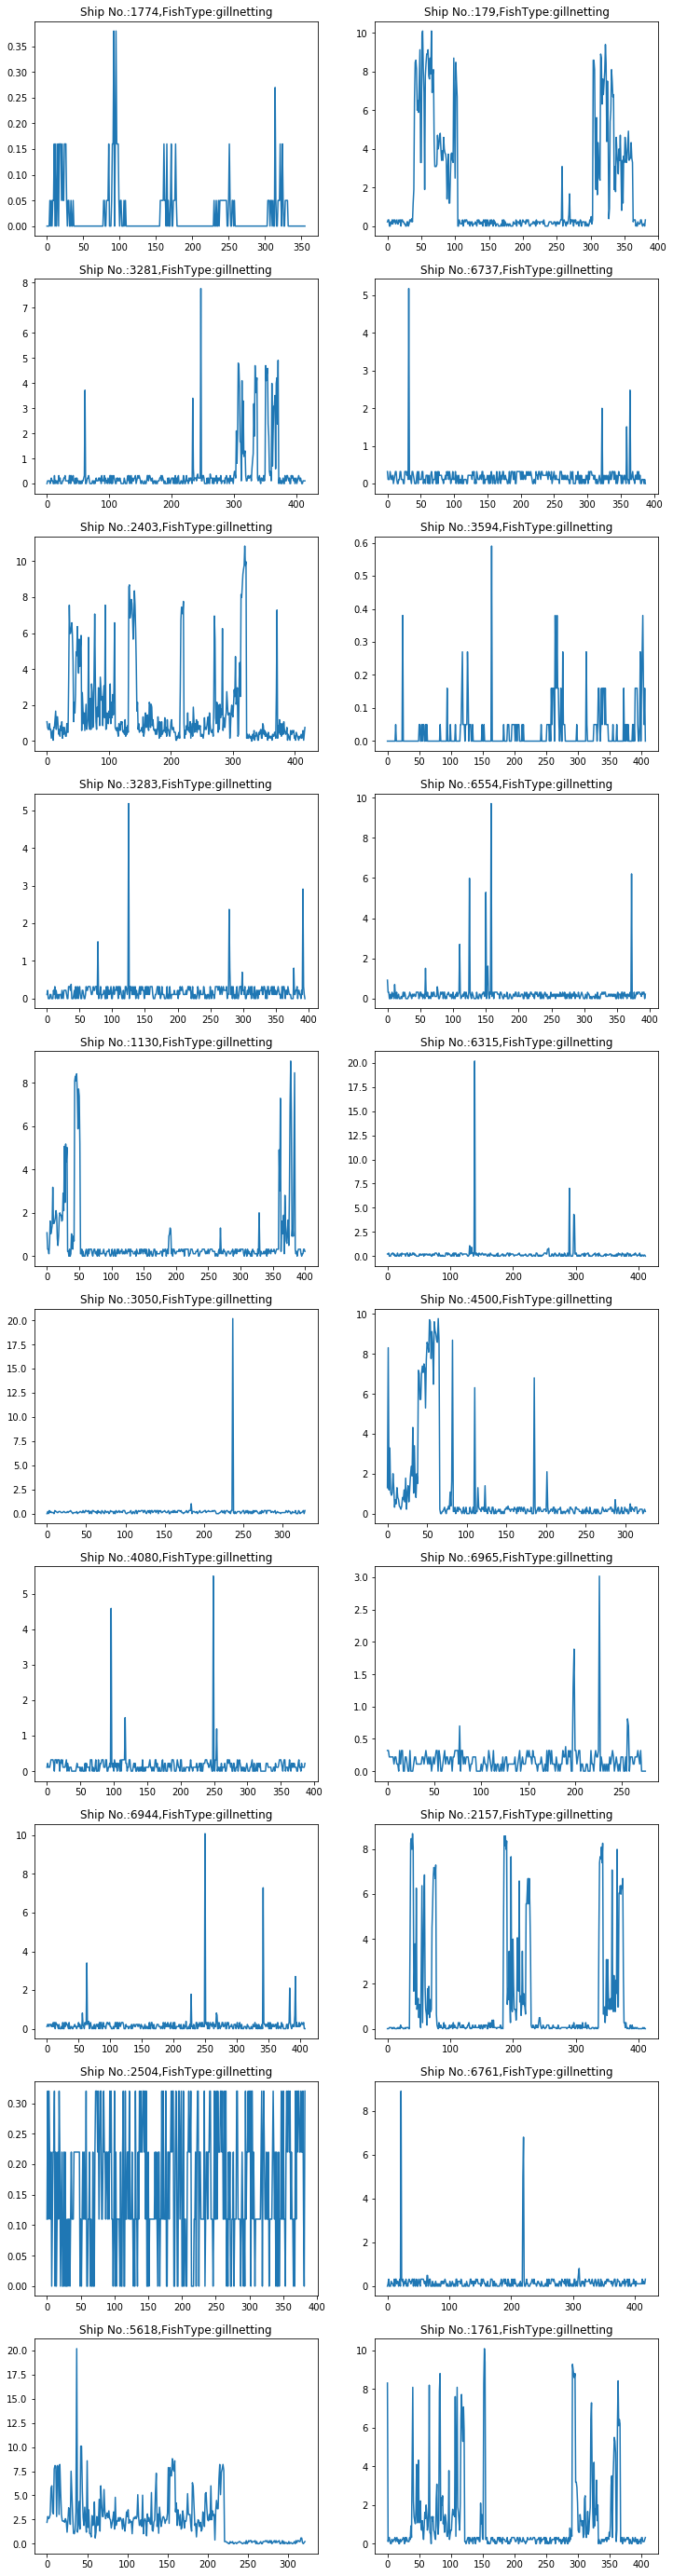

In [57]:
plot_fishing_speed(train, 'gillnet')

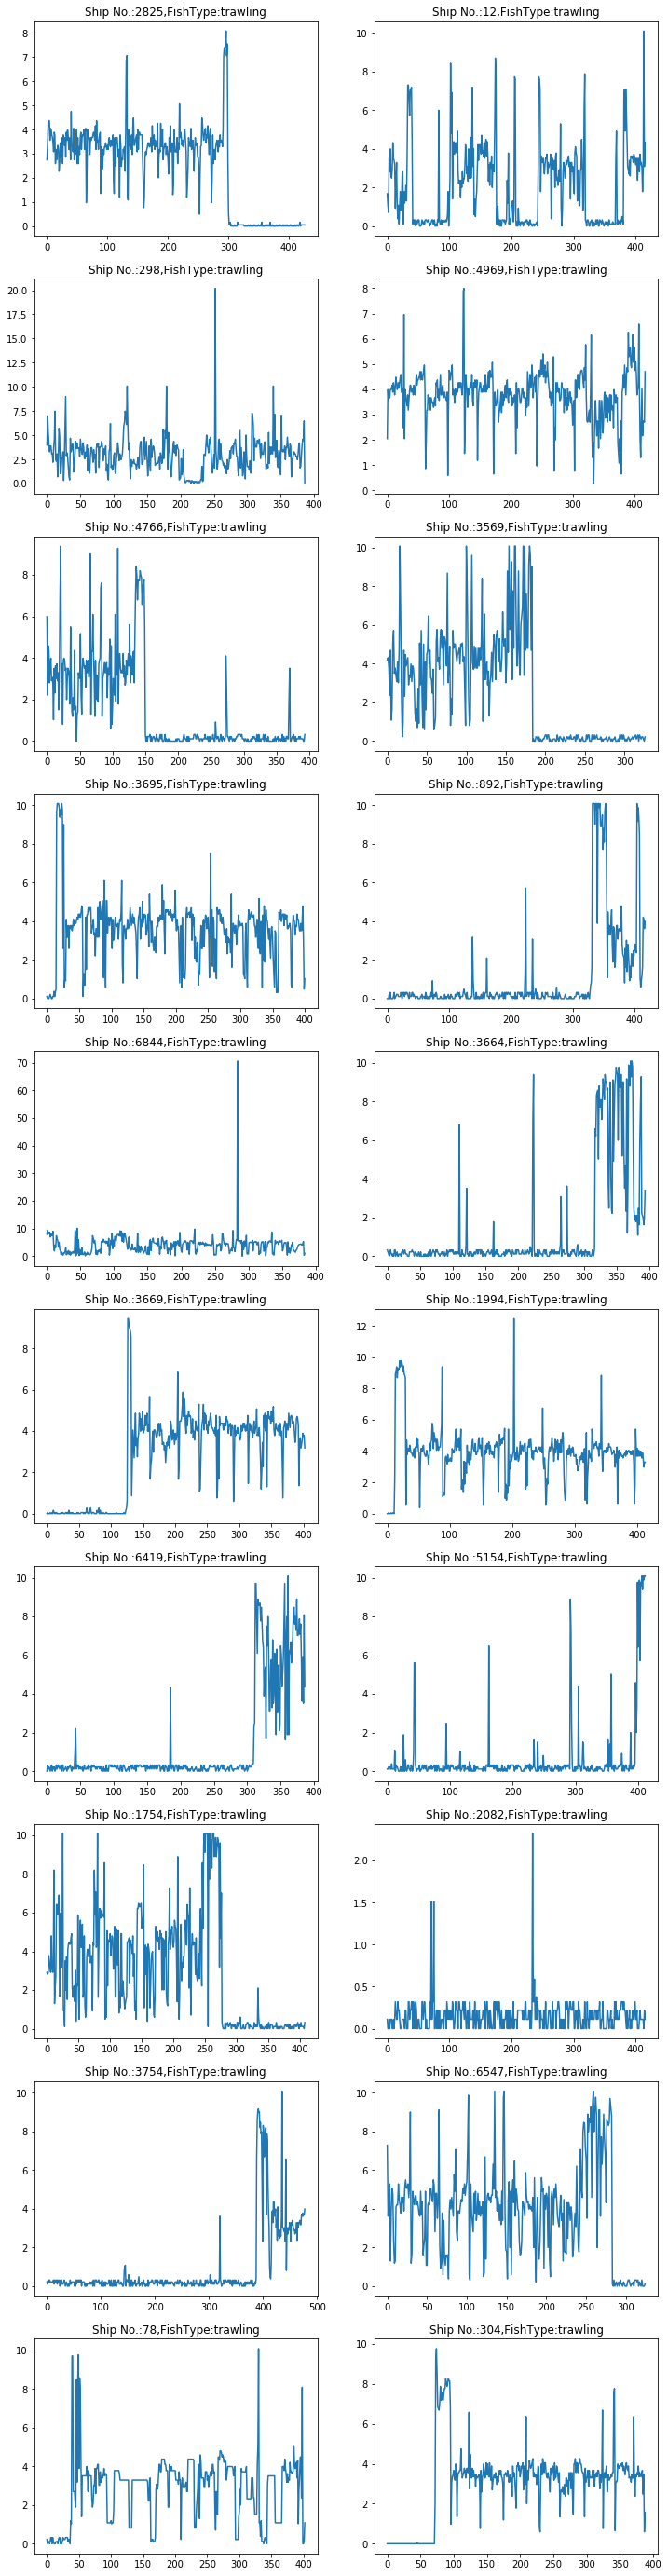

In [58]:
plot_fishing_speed(train, 'trawl')

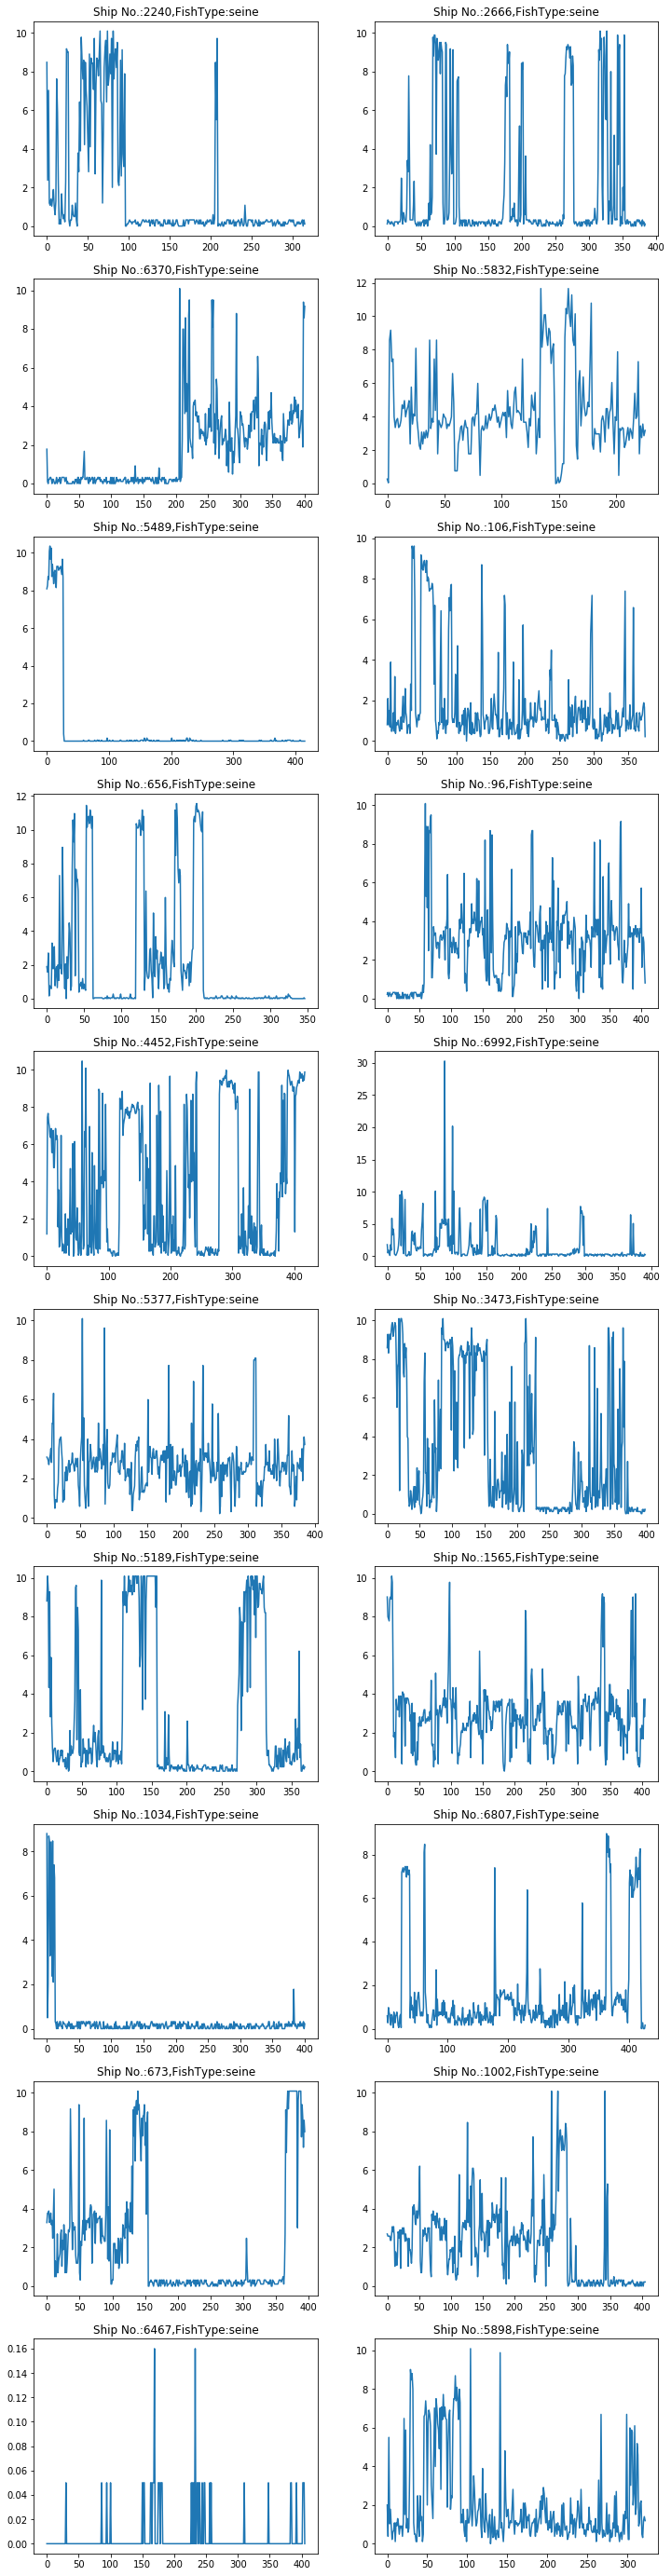

In [59]:
plot_fishing_speed(train, 'seine')

In [30]:
train.shape

(2699638, 7)

In [31]:
full = train.append(test, ignore_index = True)

fishing_data = full[:5399276]
del test, train
print ("Dataset:\n", 'full:', full.shape, 'training:', fishing_data.shape)

/Users/TH/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Dataset:
 full: (3482016, 7) training: (3482016, 7)


In [32]:
def date_checker(a):
    date = a.split()[0]
    return date

full['date'] = full.time.apply(date_checker)
fishing_data['date'] = fishing_data.time.apply(date_checker)

In [33]:
print ("All Date: {} \n, Date for training : {}".format(full.date.unique(), fishing_data.date.unique()))

All Date: ['1106' '1105' '1104' '1110' '1109' '1108' '1107' '1103' '1102' '1101'
 '1031' '1123' '1122' '1121' '1120' '1119' '1118' '1113' '1112' '1111'
 '1030' '1029' '1028' '1117' '1116' '1115' '1114'] 
, Date for training : ['1106' '1105' '1104' '1110' '1109' '1108' '1107' '1103' '1102' '1101'
 '1031' '1123' '1122' '1121' '1120' '1119' '1118' '1113' '1112' '1111'
 '1030' '1029' '1028' '1117' '1116' '1115' '1114']


In [34]:
full.columns

Index(['d', 'ship', 'time', 'type', 'v', 'x', 'y', 'date'], dtype='object')

In [60]:
def show_path(type_name):
    ids = train[train['type']==type_name]['ship'].unique()
    ids = [ids[np.random.randint(len(ids))] for x in range(10)]
    t = train[train['ship'].isin(ids)]

    f, ax = plt.subplots(5,2, figsize=(8,20))
    for index, cur_id in enumerate(ids):
        cur = t[t['ship']==cur_id]
        i = index//2
        j = index % 2
        ax[i,j].plot(cur['x'], cur['y'])
#         if i==0 and j==0:
        ax[i,j].set_title(cur_id)

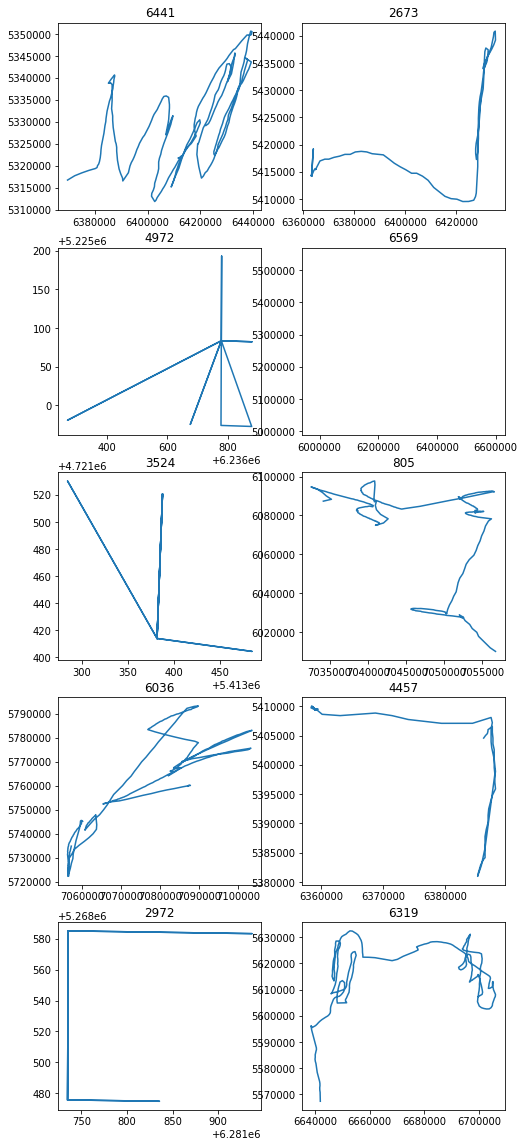

In [61]:
show_path('seine')

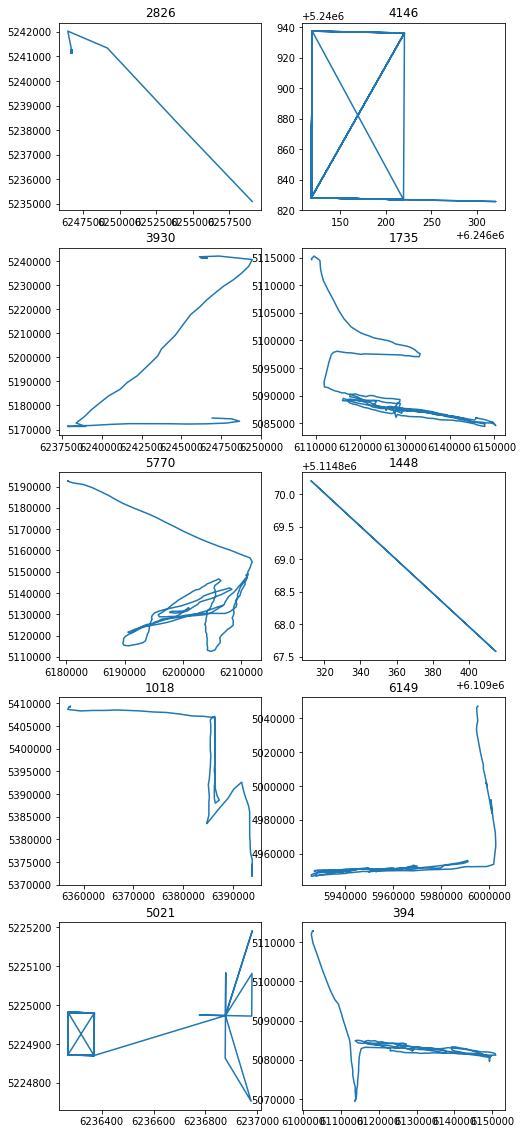

In [62]:
show_path('trawling')

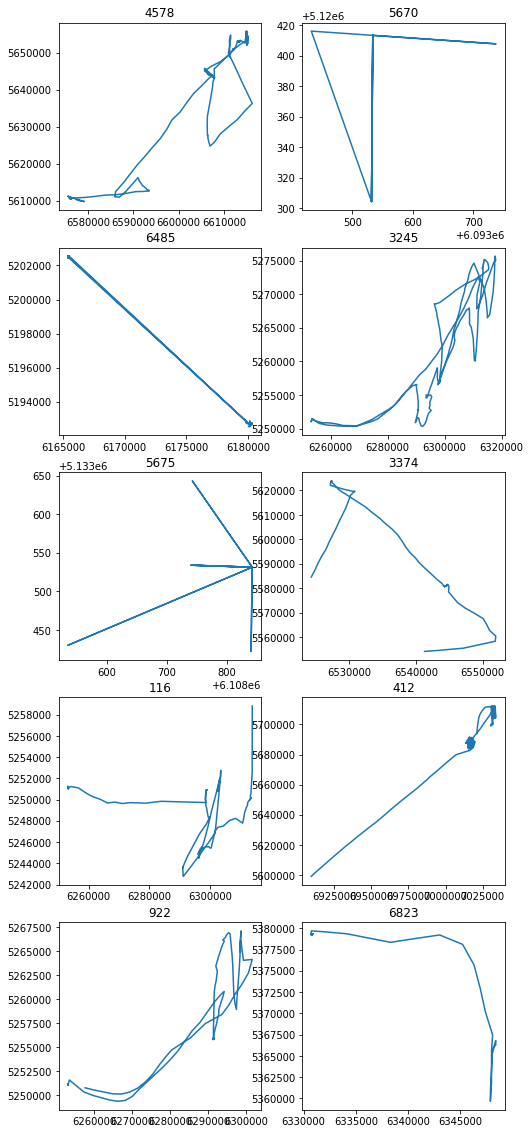

In [63]:
show_path('gillnetting')

In [64]:
#locate = train[['ship', 'x', 'y']]

In [65]:
#locate.head()
#plt.plot(locate['x'], locate['y'])
#locate['ave_locate'] = 0
#ids = locate['ship'].unique()

#for i in ids:
#    lcoate[locate['ship'] == i][]

/Users/TH/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
#def t(a):
#    return 'test'

In [71]:
#locate[locate['ship'] == 6966]['ave_locate'] = 'test'#locate[locate['ship'] == 6966]['ave_locate'].apply(t)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
#locate.head()

,ship,x,y,ave_locate
0,6966,6.265902e+06,5.279254e+06,0
1,6966,6.265902e+06,5.279254e+06,0
2,6966,6.265902e+06,5.279254e+06,0
3,6966,6.265902e+06,5.279254e+06,0
4,6966,6.265902e+06,5.279254e+06,0


In [41]:
#drop_list = train.index[train.v > 30].tolist()
#train = train.drop(drop_list, axis = 0)

In [42]:
#train.shape

(1695757, 7)

In [43]:
#train.to_hdf('input/train1.h5', 'df', mode = 'w')